In [1]:
##Generic imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
##Script specific imports for feature encoding

from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [37]:
import statsmodels.api as sm

In [1417]:
file = r'/Users/anand/Documents/Sleep/WSC - variable cross-check_sparse.xlsx'
data = r'/Users/anand/Documents/Sleep/wsc-dataset-0.2.0.csv'

In [1418]:
df = pd.read_excel(file)
data_df = pd.read_csv(data)

In [1419]:
pd.set_option('display.max_columns', None)
#data_df.head()

In [1420]:
deleted = df[df['Proposed Removal'] == 'R']
deleted_cols = deleted.iloc[:, 0]

In [1421]:
data_df = data_df.drop(deleted_cols.to_list(), axis=1)

In [1422]:
# data_df.drop(imbalanced_list, axis=1, inplace=True)
#data_df.drop_duplicates('wsc_id', inplace=True)
data_df.set_index('wsc_id', inplace=True)
##data_df.fillna(0, inplace=True)

In [1423]:
data_df.nasal_cong_none.replace({np.nan:0,'Y':1}, inplace=True)

In [1424]:
data_df.num_pregnancies.replace({np.nan:0,'Y':1}, inplace=True)

In [1425]:
# balance_cutoff = 0.975
# imbalanced_classes = []
# for col in data_df.columns:
#     _ = data_df.columns.get_loc(col)
#     if data_df.iloc[:, _].value_counts(normalize=True).head(1).values > balance_cutoff:
#         imbalanced_classes.append((col, data_df.iloc[:, _].value_counts(normalize=True).head(1).values.astype(float)))

In [1426]:
# imbalanced_list = []
# for classes in imbalanced_classes:
#     imbalanced_list.append(classes[0])

In [1427]:
objlist = []

for n in data_df.dtypes[data_df.dtypes == 'object'].index:
    objlist.append(n)

In [1428]:
## Binariser -  should work if nans are present or not...

for i,v in enumerate(objlist):
    
    ##columns with 2 variables eg. [N,Y] or [M,F]
    
    if len(data_df[v].unique()) == 2:
        ##print(data_df[v].unique(),v)
        data_df[objlist[i]].replace\
        ({data_df[objlist[i]].unique()[0]:0,data_df[objlist[i]].unique()[1]:1}, inplace=True)
        
    #### ALL columns with 3 variables - which appear like [N,Y,nan]
    if len(data_df[v].unique()) == 3:
        ##print(data_df[v].unique(),v)
        data_df[objlist[i]].replace\
        ({'N':0,'Y':1}, inplace=True)

In [1429]:
#### ONE HOT ENCODER SCRIPT

ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)


## Only variables which need OHE
X1 = data_df[['thyroid_problem']]
X2 = data_df[['hormone_therapy']]

##fit transform, extract column names, make dataframe with column names, drop nan row

X1t = ohe.fit_transform(X1)
colnames = list(ohe.get_feature_names())
X1df = pd.DataFrame(X1t, columns = colnames)
X1df.drop(columns = 'x0_nan', inplace=True)
X1df.index = data_df.index

X2t = ohe.fit_transform(X2)
colnames = list(ohe.get_feature_names())
X2df = pd.DataFrame(X2t, columns = colnames)
X2df.drop(columns = 'x0_nan', inplace=True)
X2df.index = data_df.index

frames = [data_df, X1df, X2df]
data_df = pd.concat(frames, axis = 1)

##drop original row names

data_df.drop(columns = ['thyroid_problem','hormone_therapy'], inplace=True)

# Process y

In [1430]:
targs = ['sleep_latency','tst', 'tst_rem', 'tst_nrem', 'tso', 'totsleep', 'ess','p_eval_sleep', 'a_eval_slept', 'a_eval_hour',
       'a_eval_sleep', 'ps_eds','se', 'waso','sleepiness', 'workday', 'weekend', 'ps_diff', 'ps_diff', 'ps_backsleep','ps_wakerepeat','ps_wakeup','ps_eds']

In [1431]:
imputenum = SimpleImputer(strategy = 'mean')
data_df[targs] = imputenum.fit_transform(data_df[targs])


# process X

In [1432]:
X = data_df.drop(columns = targs)
cols= X.columns
X.shape

(2570, 65)

In [1433]:
# #### Scaling numerical features - categorical features and targets removed from this listt

# numeric_features = ['creatinine', 'glucose', 'hdl', 'ldl','total_cholesterol', 'triglycerides', 'uric_acid', 'weightkg', 'bmi',
#        'headcm', 'waist_girth1', 'waist_girth2', 'hip_girth1', 'hip_girth2',
#        'neck_girth1', 'neck_girth2', 'sit_sys1', 'sit_dia1', 'sit_sys2',
#        'sit_dia2', 'hipgirthm', 'neckgirthm', 'waistgirthm', 'waisthip',
#        'sitsysm', 'sitdiam', 'zung_score', 'zung_index', 'state',
#        'trait', 'beer_week', 'wine_week', 'hard_week', 'bowls_day', 'packs_week', 'cigars_day',
#        'smoke_years', 'pack_years',
#        'naps', 'snore_freq',
#        'num_pregnancies', 'psg_cpap', 'ahi',
#        'minsao2tst', 'ptstl90', 'age', 'heightcm', 'cans_cola', 'cups_coffee',
#        'caffeine', 'alcohol_wk','eval_general', 'eval_life','eval_health', 
#        'snore_vol', 'choke_freq',
#        'apnea_freq', 'awake_freq', 'ho_score']

In [1434]:
#### Scaling numerical features - categorical features and targets removed from this listt

numeric_features = ['hdl', 'ldl','total_cholesterol', 'triglycerides', 'weightkg',
       'hipgirthm', 'neckgirthm', 'waistgirthm', 'waisthip',
       'sitsysm', 'sitdiam','packs_week', 'pack_years',
       'naps', 'snore_freq',
       'num_pregnancies','age', 'heightcm',
       'caffeine', 'alcohol_wk','eval_general', 'eval_life','eval_health', 
       'snore_vol', 'choke_freq',
       'apnea_freq', 'awake_freq']

In [1435]:
categoric = data_df.drop(columns = targs)
categoric.drop(columns = numeric_features, inplace=True)
#categoric.drop(columns =['waso', 'wsc_vst'], inplace=True)

In [1436]:
categorical_features = categoric.columns

In [1437]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

In [1438]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())])

In [1439]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),\
        ('cat', categorical_transformer, categorical_features)])

In [1440]:
prepipe = Pipeline(steps=[('preprocessor', preprocessor)])

In [1441]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),('regression', LinearRegression())])

In [1442]:
X = prepipe.fit_transform(X)

In [1443]:
X.shape

(2570, 65)

In [1451]:
X.drop(columns = ['wsc_vst'], inplace=True)

In [1445]:
X = pd.DataFrame(X, columns = cols)

In [1452]:
X

,sex,age,race,education_survey1,hdl,ldl,total_cholesterol,triglycerides,heightcm,weightkg,hipgirthm,neckgirthm,waistgirthm,waisthip,sitsysm,sitdiam,cups_coffee,caffeine,alcohol_wk,packs_week,pack_years,eval_general,eval_life,eval_health,naps,snore_freq,snore_vol,choke_freq,apnea_freq,awake_freq,nasal_cong_none,any_cvd,hypertension_ynd,stroke_ynd,diabetes_ynd,asthma_ynd,thyroid_ynd,arthritis_ynd,emphysema_ynd,apnea,menopausal_status,num_pregnancies,asthma_med,cholesterol_med,depression_med,htn_med,narcotics_med,decongestants_med,antihistamines_med,anxiety_med,diabetes_med,androgen_med,sedative_med,stimulants_med,thyroid_med,x0_Hyperthyroid,x0_Hypothyroid,x0_Infection,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
0,0.837209,0.688617,0.144578,-0.089286,-0.618182,0.188679,-0.364465,0.226920,-0.619048,0.153846,0.000000,0.000,-0.50,-0.666667,0.0,-0.666667,0.583333,0.666667,0.0,0.0,-1.0,-1.0,-0.333333,-0.125,0.0,0.0,1.0,0.0,5.0,6.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.720930,0.464127,0.734940,0.089286,-0.363636,0.094340,0.045558,0.581752,-0.380952,0.384615,0.000000,0.000,-0.50,-1.000000,0.0,-0.166667,0.750000,0.666667,0.2,0.0,-1.0,-1.0,-0.333333,-0.125,0.0,0.0,2.0,0.0,5.0,6.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.209302,0.566168,-0.096386,-0.535714,0.000000,-1.320755,-0.865604,-1.174345,0.238095,0.538462,0.000000,0.000,-0.50,-1.000000,0.0,-0.833333,0.083333,0.666667,-0.2,0.0,0.0,0.0,-0.333333,-0.125,0.0,0.0,1.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.441860,2.055964,-0.518072,-0.714286,-0.060606,-0.981132,-1.116173,-1.497380,-0.047619,0.538462,0.000000,0.000,-0.50,-1.000000,0.0,-0.583333,-0.083333,-0.333333,0.0,2.0,-1.0,0.0,1.000000,-0.125,0.0,0.0,2.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.767442,0.341678,-0.481928,0.982143,2.454545,0.188679,1.958998,0.361337,0.809524,1.000000,4.349169,4.125,0.00,1.666667,6.0,-0.250000,-1.000000,-0.666667,-0.4,0.0,-1.0,1.0,1.000000,-0.125,0.0,0.0,1.0,1.0,5.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,0.000000,0.280453,0.879518,-0.946429,-0.727273,-0.283019,-0.820046,-0.406865,0.142857,0.153846,0.000000,0.000,-0.50,-1.000000,2.0,-0.250000,-0.750000,0.666667,-0.2,0.0,0.0,-1.0,-0.333333,-0.125,0.0,0.0,2.0,1.0,5.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2566,0.348837,0.933515,1.554217,-0.821429,-0.515152,-0.566038,-0.523918,-0.151762,0.619048,0.384615,0.000000,0.000,-0.50,-1.000000,0.0,0.166667,-0.583333,0.333333,0.0,0.0,0.0,0.0,-0.333333,-0.125,0.0,0.0,3.0,1.0,5.0,3.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2567,0.395349,0.525351,-0.433735,-0.928571,-1.133333,-0.660377,-0.774487,0.151762,-0.380952,-0.384615,-4.650831,0.875,-0.50,-0.666667,0.0,-0.750000,-0.333333,3.000000,-0.4,0.0,-1.0,0.0,-0.333333,-0.125,0.0,0.0,1.0,0.0,5.0,3.0,10.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2568,0.511628,0.280453,-0.927711,-0.910714,-0.818182,-0.849057,-0.091116,0.929359,-0.523810,-0.230769,3.349169,5.000,1.75,-0.333333,0.0,-0.333333,-0.333333,-0.333333,

In [1398]:
#targs = ['tst', 'tst_rem', 'tst_nrem', 'tso', 'totsleep', 'ess','p_eval_sleep', 'a_eval_slept', 'a_eval_hour',
     ##  'a_eval_sleep', 'ps_eds','se', 'waso','sleepiness', 'workday', 'weekend', 'ps_diff', 'ps_diff', 'ps_backsleep','ps_wakerepeat','ps_wakeup','ps_eds']

<AxesSubplot:>

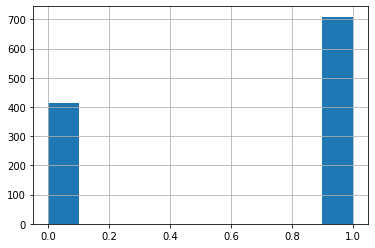

In [1453]:
waso.hist()

In [1521]:
waso = data_df.waso
waso = waso.reset_index(drop=True)
waso[(waso <= 53)] = 0
waso[(waso > 53)] = 1


In [1455]:
se = data_df.se
se = se.reset_index(drop=True)

a = 85
b = 95

se[(se < a) | (se > b)] = 1
se[(se >= a) & (se <= b)] = 0

In [1502]:
tst = data_df.tst
tst = tst.reset_index(drop=True)
a = 370
b = 410

tst[(tst < a) | (tst > b)] = 1
tst[(tst >= a) & (tst <= b)] = 0

In [1530]:
tso = data_df.tso
tso = tso.reset_index(drop=True)

a = 14
b = 17

tso[(tso < a) | (tso > b)] = 1
tso[(tso >= a) & (tso <= b)] = 0

((2570,), <AxesSubplot:>)

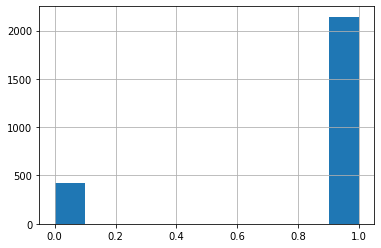

In [1531]:
y = tso
y = y.reset_index(drop=True)
y.shape, y.hist()

In [1532]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                    random_state=42)

In [1533]:
y_train = y_train.astype('int')

In [1534]:
y_train.value_counts()

1    1819
0     365
Name: tso, dtype: int64

In [1535]:
#model1 = LogisticRegression(penalty = 'l1', solver = 'liblinear')
model1 = LogisticRegression()

In [1536]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [1537]:
model1 = RandomForestClassifier()

In [1539]:
cv_results = cross_validate(model1, X_train, y_train, cv=5, scoring=['accuracy', 'recall', 'precision'])
sorted(cv_results.keys())
cv_results['test_accuracy'].mean(), cv_results['test_recall'].mean(), cv_results['test_precision'].mean()

(0.8333340331282933, 1.0, 0.8332581077882111)

In [1412]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, recall_score

In [1493]:
model1.fit(X_train, y_train)
accuracy_score(y_test, model1.predict(X_test)), recall_score(y_test, model1.predict(X_test))

(0.6709844559585493, 0.8991596638655462)

In [1414]:
dummy = DummyClassifier(strategy = "prior")
dummy.fit(X_train, y_train)


DummyClassifier()

In [1415]:
accuracy_score(y_test, dummy.predict(X_test)), recall_score(y_test, dummy.predict(X_test))

(0.7928994082840237, 1.0)

In [1416]:
X_train.columns.to_list()

['wsc_vst',
 'sex',
 'age',
 'race',
 'education_survey1',
 'hdl',
 'ldl',
 'total_cholesterol',
 'triglycerides',
 'heightcm',
 'weightkg',
 'hipgirthm',
 'neckgirthm',
 'waistgirthm',
 'waisthip',
 'sitsysm',
 'sitdiam',
 'cups_coffee',
 'caffeine',
 'alcohol_wk',
 'packs_week',
 'pack_years',
 'eval_general',
 'eval_life',
 'eval_health',
 'naps',
 'snore_freq',
 'snore_vol',
 'choke_freq',
 'apnea_freq',
 'awake_freq',
 'nasal_cong_none',
 'any_cvd',
 'hypertension_ynd',
 'stroke_ynd',
 'diabetes_ynd',
 'asthma_ynd',
 'thyroid_ynd',
 'arthritis_ynd',
 'emphysema_ynd',
 'apnea',
 'menopausal_status',
 'num_pregnancies',
 'asthma_med',
 'cholesterol_med',
 'depression_med',
 'htn_med',
 'narcotics_med',
 'decongestants_med',
 'antihistamines_med',
 'anxiety_med',
 'diabetes_med',
 'androgen_med',
 'sedative_med',
 'stimulants_med',
 'thyroid_med',
 'x0_Hyperthyroid',
 'x0_Hypothyroid',
 'x0_Nodule',
 'x0_Thyroid Cancer',
 'x0_Unknown',
 'x0_C',
 'x0_N',
 'x0_P']

# Modelling

<AxesSubplot:>

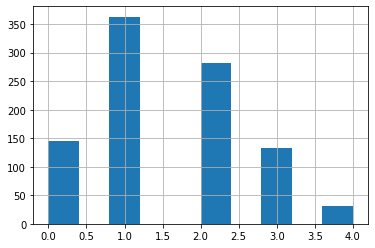

In [681]:
y_train.hist()

In [682]:
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, test_size=0.33)

In [683]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
##, recall_score, precision_score, accuracy_score

In [685]:
cv_results = cross_validate(model1, Xtrain, ytrain, cv=5, scoring=['neg_mean_absolute_error'])
sorted(cv_results.keys())

['fit_time', 'score_time', 'test_neg_mean_absolute_error']

In [686]:
cv_results['test_neg_mean_absolute_error'].mean()

-0.7982318017472406

In [ ]:
model = LogisticRegression(multi_class='ovr', max_iter = 1000)

In [ ]:
model.fit(Xtrain_tr, ytrainbin_tr)
ypred = model.predict(Xtrain_te)

In [118]:
dummy = DummyRegressor(strategy='mean')

In [119]:
dummy.fit(Xtrain, ytrain)

DummyRegressor()

In [120]:
dummy.score(Xval, yval)

-0.0036763961072932005

In [121]:
mean_absolute_error(yval, dummy.predict(Xval))

47.29975706088383

(315, 111)